# Challenge 1

In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
def is_running_on_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ and os.environ["KAGGLE_KERNEL_RUN_TYPE"] == "Interactive"
DATA_PATH = '/kaggle/input/aerial-cactus/' if is_running_on_kaggle() else 'data/'
print('Running on Kaggle' if is_running_on_kaggle() else 'Running locally')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Running on Kaggle


Import required libraries

In [51]:
import torch
import torchvision
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm

In [52]:
# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


Define some useful constants.

In [53]:
ANNOTATIONS_FILE = DATA_PATH + 'train.csv'
IMG_DIR = DATA_PATH + 'train/train/'
CHECKPOINT_DIR = '/kaggle/working/' if is_running_on_kaggle() else 'checkpoints/'

SEED = 42
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
TRAIN_SPLIT = 0.8
EPOCHS = 20 if is_running_on_kaggle() else 1

Set the manual seed.

In [54]:
torch.manual_seed(42)

Extend **Dataset** class for the **DatasetLoader** (define a mapping for images and labels).

In [55]:
from torchvision.io import read_image

class CactusDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

TODO: Try to preprocess like in ImProc

Instanciate a **Dataset** object on the training (+validation) data.

In [56]:
# Imagenet mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [57]:
import torchvision.transforms as transforms

# Transformation for the image data
transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=mean, std=std),
])

In [58]:
# Create the dataset object
trainval_data = CactusDataset(ANNOTATIONS_FILE, IMG_DIR, transform=transform)

In [59]:
# Print the shape of the first image in the dataset
print(trainval_data[0][0].shape)

torch.Size([3, 224, 224])


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).

  warnings.warn(


Split the dataset into train + validation

In [60]:
from torch.utils.data import random_split

# Define the sizes of training and validation sets
train_size = int(TRAIN_SPLIT * len(trainval_data))
val_size = len(trainval_data) - train_size

# Split the dataset into training and validation sets
train_data, val_data = random_split(trainval_data, [train_size, val_size])

# Print the sizes of the training and validation sets
print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))

Training set size: 14000

Validation set size: 3500


Let's define our first model.\
We are going to use the ResNet18 pretrained model and then we are going to add 1 linear FC output layer. The output will be a real value that we will feed into a Sigmoid function to squash it into the $[0, 1]$ interval, and we will do the classification by comparing the output of the Sigmoid with the $0.5$ treshold.\
Since we don't want to adjust ResNet18 weights, we are going to set the **requires_grad** property to **False** for each of its parameters.

In [61]:
from torchvision.models import resnet18, ResNet18_Weights

class ResnetClassificator(nn.Module):
    def __init__(self, fc_size=None):
        super(ResnetClassificator, self).__init__()
        
        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for param in resnet.parameters():
            param.requires_grad = False
        
        self.resnet = resnet
        self.fc_size = 1 if fc_size is None or fc_size < 2 else fc_size
        if self.fc_size < 2:
            self.fc1 = nn.Linear(resnet.fc.out_features, 1)
        else:
            self.fc1 = nn.Linear(resnet.fc.out_features, fc_size)
            self.fc2 = nn.Linear(fc_size, 1)

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc1(x)
        if self.fc_size != 1:
            x = self.fc2(x)
        return x

At this point, let's train our model.

In [62]:
# Utility function for saving epochs checkpoints
def save_checkpoint(model, optimizer, loss, dir, desc):
    checkpoint_dir = os.path.join(CHECKPOINT_DIR, dir)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{desc}.pt')
    torch.save({
        'desc': desc,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)

# Utility function for loading epochs checkpoints
def load_checkpoint(model, optimizer, dir, desc):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, dir, f'checkpoint_{desc}.pt')
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    return model, optimizer, loss

In [63]:
# Training loop (1 epoch)
def train_model(train_dataloader, model, criterion, optimizer, checkpoint=False, desc='Training', dir_checkpoint=None):
    avg_train_loss = 0
    train_bar = tqdm(train_dataloader, desc=desc, leave=False)
    
    model.train()
    for X, y in train_bar:
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X.float())
        y = y.reshape(-1, 1).float()
        loss = criterion(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the average loss
        avg_train_loss += loss.item() * len(y)

        # Update the loading bar
        train_bar.set_postfix({'loss': loss.item()})
        
    avg_train_loss = avg_train_loss / len(train_dataloader.dataset)
    train_bar.set_postfix({'loss': avg_train_loss})
    train_bar.close()

    if checkpoint:
        save_checkpoint(model, optimizer, avg_train_loss, dir_checkpoint, desc)

    return avg_train_loss

In [64]:
# Compute validation loss and error rate
def evaluate(val_dataloader, model, criterion, desc='Validation'):
    avg_val_loss = 0
    errors = []
    val_bar = tqdm(val_dataloader, desc=desc, leave=False)

    model.eval()
    with torch.no_grad():
        for X, y in val_bar:
            X = X.to(device)
            y = y.to(device)

            # Compute prediction and loss
            pred = model(X.float())
            y = y.reshape(-1, 1).float()
            loss = criterion(pred, y)

            # Save errors for error rate
            pred = nn.Sigmoid()(pred) > 0.5
            errors += pred != y

            # Update the average loss
            avg_val_loss += loss.item() * len(y)

            # Update the loading bar
            val_bar.set_postfix({'loss': loss.item()})
    
    avg_val_loss = avg_val_loss / len(val_dataloader.dataset)
    val_bar.set_postfix({'loss': avg_val_loss})
    val_bar.close()
    return avg_val_loss, errors


In [ ]:
# Early stopping
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


------- Training with fc_size=1 -------


Epoch 1/20 - Train Loss: 0.1279 - Val Loss: 0.0748 - Error Rate: 0.0289


Epoch 2/20 - Train Loss: 0.0820 - Val Loss: 0.0588 - Error Rate: 0.0214


Epoch 3/20 - Train Loss: 0.0712 - Val Loss: 0.0575 - Error Rate: 0.0194


Epoch 4/20 - Train Loss: 0.0668 - Val Loss: 0.0616 - Error Rate: 0.0231


Epoch 5/20 - Train Loss: 0.0641 - Val Loss: 0.0565 - Error Rate: 0.0214


Epoch 6/20 - Train Loss: 0.0622 - Val Loss: 0.0480 - Error Rate: 0.0177


Epoch 7/20 - Train Loss: 0.0614 - Val Loss: 0.0480 - Error Rate: 0.0180


Epoch 8/20 - Train Loss: 0.0583 - Val Loss: 0.0605 - Error Rate: 0.0223


Epoch 9/20 - Train Loss: 0.0596 - Val Loss: 0.0450 - Error Rate: 0.0160


Epoch 10/20 - Train Loss: 0.0531 - Val Loss: 0.0467 - Error Rate: 0.0177


Epoch 11/20 - Train Loss: 0.0571 - Val Loss: 0.0451 - Error Rate: 0.0183


Epoch 12/20 - Train Loss: 0.0571 - Val Loss: 0.0450 - Error Rate: 0.0163


Epoch 13/20 - Train Loss: 0.0547 - Val Loss: 0.0447 - Error Rate: 0.0166


Epoch 14/20 - Train Loss: 0.0585 - Val Loss: 0.0472 - Error Rate: 0.0169


Epoch 15/20 - Train Loss: 0.0582 - Val Loss: 0.0484 - Error Rate: 0.0174


Epoch 16/20 - Train Loss: 0.0543 - Val Loss: 0.0546 - Error Rate: 0.0197


Epoch 17/20 - Train Loss: 0.0491 - Val Loss: 0.0485 - Error Rate: 0.0183


Epoch 18/20 - Train Loss: 0.0505 - Val Loss: 0.0450 - Error Rate: 0.0174


Epoch 19/20 - Train Loss: 0.0525 - Val Loss: 0.0441 - Error Rate: 0.0160


Epoch 20/20 - Train Loss: 0.0529 - Val Loss: 0.0460 - Error Rate: 0.0163


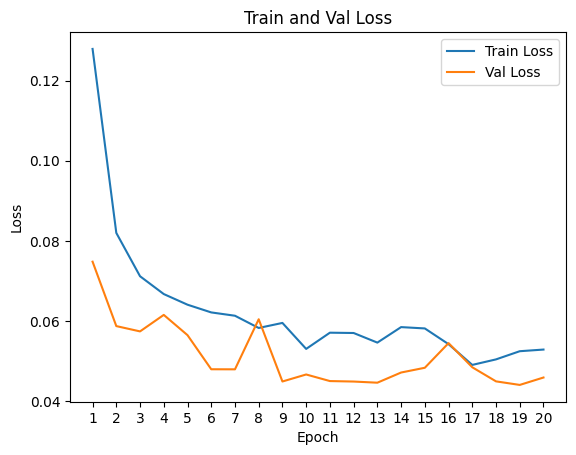

------- Training with fc_size=2 -------


Epoch 1/20 - Train Loss: 0.1398 - Val Loss: 0.0709 - Error Rate: 0.0263


Epoch 2/20 - Train Loss: 0.0819 - Val Loss: 0.0570 - Error Rate: 0.0206


Epoch 3/20 - Train Loss: 0.0634 - Val Loss: 0.0547 - Error Rate: 0.0206


Epoch 4/20 - Train Loss: 0.0645 - Val Loss: 0.0485 - Error Rate: 0.0180


Epoch 5/20 - Train Loss: 0.0603 - Val Loss: 0.0501 - Error Rate: 0.0197


Epoch 6/20 - Train Loss: 0.0597 - Val Loss: 0.0510 - Error Rate: 0.0206


Epoch 7/20 - Train Loss: 0.0582 - Val Loss: 0.0459 - Error Rate: 0.0160


Epoch 8/20 - Train Loss: 0.0608 - Val Loss: 0.0597 - Error Rate: 0.0223


Epoch 9/20 - Train Loss: 0.0561 - Val Loss: 0.0505 - Error Rate: 0.0191


Epoch 10/20 - Train Loss: 0.0586 - Val Loss: 0.0497 - Error Rate: 0.0189


Epoch 11/20 - Train Loss: 0.0551 - Val Loss: 0.0471 - Error Rate: 0.0180


Epoch 12/20 - Train Loss: 0.0541 - Val Loss: 0.0454 - Error Rate: 0.0177


Epoch 13/20 - Train Loss: 0.0524 - Val Loss: 0.0464 - Error Rate: 0.0183


Epoch 14/20 - Train Loss: 0.0514 - Val Loss: 0.0444 - Error Rate: 0.0186


Epoch 15/20 - Train Loss: 0.0564 - Val Loss: 0.0440 - Error Rate: 0.0163


Epoch 16/20 - Train Loss: 0.0535 - Val Loss: 0.0536 - Error Rate: 0.0180


Epoch 17/20 - Train Loss: 0.0507 - Val Loss: 0.0460 - Error Rate: 0.0160


Epoch 18/20 - Train Loss: 0.0509 - Val Loss: 0.0468 - Error Rate: 0.0189


Epoch 19/20 - Train Loss: 0.0519 - Val Loss: 0.0485 - Error Rate: 0.0180


Epoch 20/20 - Train Loss: 0.0534 - Val Loss: 0.0470 - Error Rate: 0.0186


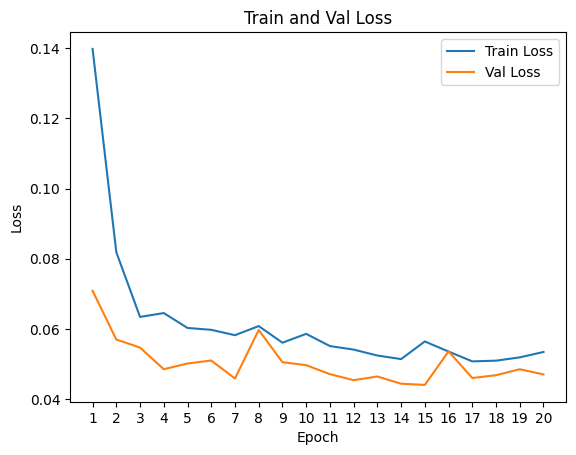

------- Training with fc_size=4 -------


Epoch 1/20 - Train Loss: 0.1213 - Val Loss: 0.0595 - Error Rate: 0.0214


Epoch 2/20 - Train Loss: 0.0709 - Val Loss: 0.0536 - Error Rate: 0.0226


Epoch 3/20 - Train Loss: 0.0690 - Val Loss: 0.0548 - Error Rate: 0.0206


Epoch 4/20 - Train Loss: 0.0615 - Val Loss: 0.0505 - Error Rate: 0.0194


Epoch 5/20 - Train Loss: 0.0590 - Val Loss: 0.0475 - Error Rate: 0.0177


Epoch 6/20 - Train Loss: 0.0618 - Val Loss: 0.0666 - Error Rate: 0.0251


Epoch 7/20 - Train Loss: 0.0563 - Val Loss: 0.0504 - Error Rate: 0.0211


Epoch 8/20 - Train Loss: 0.0608 - Val Loss: 0.0443 - Error Rate: 0.0157


Epoch 9/20 - Train Loss: 0.0506 - Val Loss: 0.0481 - Error Rate: 0.0157


Epoch 10/20 - Train Loss: 0.0598 - Val Loss: 0.0468 - Error Rate: 0.0177


Epoch 11/20 - Train Loss: 0.0540 - Val Loss: 0.0464 - Error Rate: 0.0160


Epoch 12/20 - Train Loss: 0.0553 - Val Loss: 0.0465 - Error Rate: 0.0171


Epoch 13/20 - Train Loss: 0.0538 - Val Loss: 0.0454 - Error Rate: 0.0169


Epoch 14/20 - Train Loss: 0.0519 - Val Loss: 0.0459 - Error Rate: 0.0183


Epoch 15/20 - Train Loss: 0.0521 - Val Loss: 0.0542 - Error Rate: 0.0191


Epoch 16/20 - Train Loss: 0.0556 - Val Loss: 0.0457 - Error Rate: 0.0174


Epoch 17/20 - Train Loss: 0.0527 - Val Loss: 0.0458 - Error Rate: 0.0180


Epoch 18/20 - Train Loss: 0.0492 - Val Loss: 0.0448 - Error Rate: 0.0171


Epoch 19/20 - Train Loss: 0.0517 - Val Loss: 0.0505 - Error Rate: 0.0177


Epoch 20/20 - Train Loss: 0.0534 - Val Loss: 0.0450 - Error Rate: 0.0160


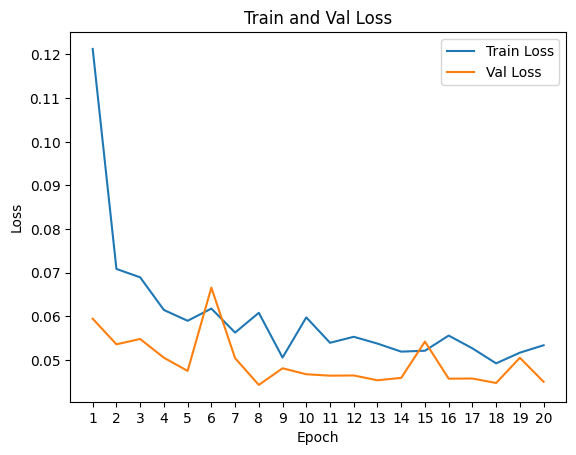

------- Training with fc_size=8 -------


Epoch 1/20 - Train Loss: 0.1103 - Val Loss: 0.0575 - Error Rate: 0.0206


Epoch 2/20 - Train Loss: 0.0717 - Val Loss: 0.0516 - Error Rate: 0.0203


Epoch 3/20 - Train Loss: 0.0691 - Val Loss: 0.0574 - Error Rate: 0.0200


Epoch 4/20 - Train Loss: 0.0662 - Val Loss: 0.0468 - Error Rate: 0.0169


Epoch 5/20 - Train Loss: 0.0642 - Val Loss: 0.0450 - Error Rate: 0.0160


Epoch 6/20 - Train Loss: 0.0596 - Val Loss: 0.0503 - Error Rate: 0.0200


Epoch 7/20 - Train Loss: 0.0578 - Val Loss: 0.0489 - Error Rate: 0.0174


Epoch 8/20 - Train Loss: 0.0539 - Val Loss: 0.0471 - Error Rate: 0.0183


Epoch 9/20 - Train Loss: 0.0554 - Val Loss: 0.0475 - Error Rate: 0.0166


Epoch 10/20 - Train Loss: 0.0546 - Val Loss: 0.0461 - Error Rate: 0.0169


Epoch 11/20 - Train Loss: 0.0577 - Val Loss: 0.0479 - Error Rate: 0.0189


Epoch 12/20 - Train Loss: 0.0558 - Val Loss: 0.0462 - Error Rate: 0.0166


Epoch 13/20 - Train Loss: 0.0563 - Val Loss: 0.0508 - Error Rate: 0.0183


Epoch 14/20 - Train Loss: 0.0502 - Val Loss: 0.0470 - Error Rate: 0.0177


Epoch 15/20 - Train Loss: 0.0531 - Val Loss: 0.0460 - Error Rate: 0.0174


Epoch 16/20 - Train Loss: 0.0491 - Val Loss: 0.0502 - Error Rate: 0.0174


Epoch 17/20 - Train Loss: 0.0551 - Val Loss: 0.0475 - Error Rate: 0.0171


Epoch 18/20 - Train Loss: 0.0559 - Val Loss: 0.0517 - Error Rate: 0.0194


Epoch 19/20 - Train Loss: 0.0554 - Val Loss: 0.0450 - Error Rate: 0.0171


Epoch 20/20 - Train Loss: 0.0505 - Val Loss: 0.0473 - Error Rate: 0.0163


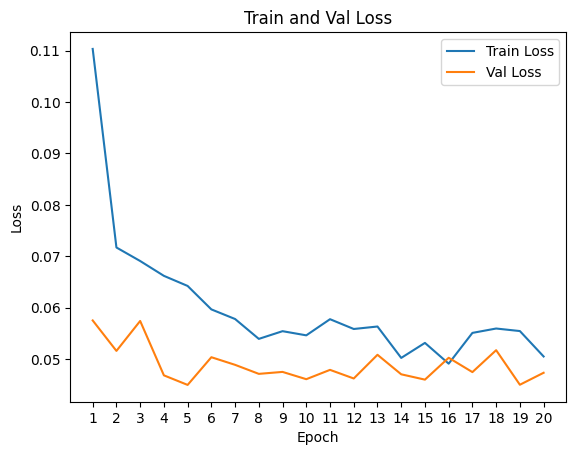

In [65]:
fc_sizes = [1, 2, 4, 8]

for fc_size in fc_sizes:
    print(f'------- Training with fc_size={fc_size} -------')
    # Create the model
    model = ResnetClassificator(fc_size).to(device)

    # Define the loss function and optimizer
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Create the dataloaders
    train_dataloader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, BATCH_SIZE, shuffle=False)

    train_losses = []
    val_losses = []
    early_stopper = EarlyStopper(patience=3, min_delta=10)

    for epoch in range(EPOCHS):
        train_loss = train_model(train_dataloader, model, criterion, optimizer, checkpoint=True, desc=f'TrainingEpoch{(epoch + 1):02d}', dir_checkpoint=f'fc_size_{fc_size}')
        val_loss, errors = evaluate(val_dataloader, model, criterion, desc=f'ValidationEpoch{(epoch + 1):02d}')
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        error_rate = sum(errors) / len(val_data)
        print(f'Epoch {epoch + 1}/{EPOCHS} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Error Rate: {error_rate.item():.4f}')

        if early_stopper.early_stop(val_loss):             
          break

    # Plot the train and val loss
    epochs = [i+1 for i in range(len(train_losses))]
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')

    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.ylabel('Loss')
    plt.title('Train and Val Loss')
    plt.legend()
    plt.grid()
    plt.show()